<a href="https://colab.research.google.com/github/oekwonu/dsba6211-summer2024-labs/blob/main/notebooks/dsba6211_summer2024_lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [1]:
%%capture
!pip install skforecast
!pip install pmdarima

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima
# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data

In [26]:
url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1138&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ENPLANE&scale=left&cosd=2000-01-01&coed=2024-02-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2024-06-27&revision_date=2024-06-27&nd=2000-01-01"

df = pd.read_csv(url, index_col=0, parse_dates=True)
df.head()

,ENPLANE
DATE,
2000-01-01,46492.0
2000-02-01,48526.0
2000-03-01,58764.0
2000-04-01,56032.0
2000-05-01,58201.0


For this data, we'll use:
- training data: 2000 to 2015
- validation data: 2016 to 2017
- test data: 2018 to 2019

In [44]:
# filter df only by 2010 to most recent
df = df['2010-01-01':'2019-12-31']

Train dates : 2010-01-01 00:00:00 --- 2016-12-01 00:00:00  (n=84)
Test dates  : 2017-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=36)


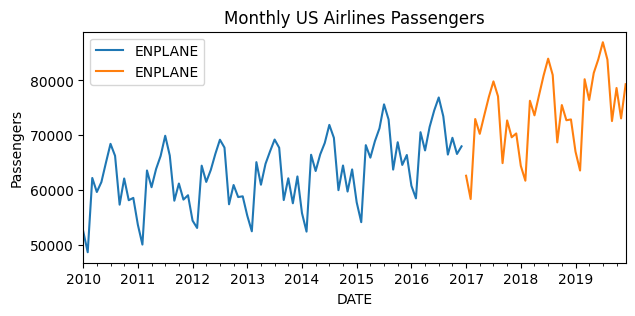

In [45]:
end_train = '2016-12-31 23:59:59'
print(
    f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  "
    f"(n={len(df.loc[:end_train])})"
)
print(
    f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  "
    f"(n={len(df.loc[end_train:])})"
)
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

# Plot
# ======================================================================================
fig, ax=plt.subplots(figsize=(7, 3))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.set_title('Monthly US Airlines Passengers')
ax.set_ylabel('Passengers')
ax.legend();

## Problem 1: Create Baseline

Fill in the `!<-- fill in -->!` with the correct syntax to create a naive seasonal forecast that is the value of the same month of the previous year.

Hint: to find [the docs for help](https://skforecast.org/0.12.1/user_guides/forecasting-baseline.html#forecasterequivalentdate).

In [46]:
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import select_features

# Convert index to DatetimeIndex with frequency
data_train.index = pd.to_datetime(data_train.index)
data_train = data_train.asfreq('MS')

# Create baseline: value of the same month of the previous year
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(months = 12),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data_train['ENPLANE'])
baseline_predict = forecaster.predict(steps=len(data_test))
forecaster

ForecasterEquivalentDate 
Offset: <DateOffset: months=12> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 12 
Training range: [Timestamp('2010-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Creation date: 2024-07-23 01:25:02 
Last fit date: 2024-07-23 01:25:02 
Skforecast version: 0.12.1 
Python version: 3.10.12 
Forecaster id: None 

## Problem 2: LightGBM

1. Create `ForecasterAugreg` with `LGBMRegressor` as the regressor setting the `lags` to 12 and the `differentiation` to 1. Also within `LGBMRegressor`, set the `random_state` to 123. Keep all other default parameters.

2. Fit the model, use `.predict()` with the same number of steps of the `data_test` and name its predictions to `lgbm_predict`.

3. Print out the details of your model by including the name of your model (e.g., if your model is named `forecaster`, then just run `forecaster`

4. Then run your model with `.get_feature_importances()`. What are the top 3 most important features in your model?

For an example of a similar pipeline, see [here](https://skforecast.org/0.12.1/user_guides/forecasting-xgboost-lightgbm#forecaster-lightgbm).

Another difference from that examples is **do not** include exogenous variables.

In [48]:
from lightgbm import LGBMRegressor

# Create and fit forecaster
forecaster2 = ForecasterAutoreg(
    regressor = LGBMRegressor(random_state=123),
    lags      = 12,
    differentiation = 1
)
forecaster2.fit(y=data_train['ENPLANE'])
lgbm_predict = forecaster2.predict(steps=len(data_test))

# ==============================================================================
forecaster2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 71, number of used features: 12
[LightGBM] [Info] Start training from score 201.295775
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

ForecasterAutoreg 
Regressor: LGBMRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: 1 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-07-23 01:25:42 
Last fit date: 2024-07-23 0

In [49]:
forecaster2.get_feature_importances()

,feature,importance
11,lag_12,33
7,lag_8,16
8,lag_9,16
1,lag_2,13
5,lag_6,11
9,lag_10,10
4,lag_5,8
0,lag_1,7
6,lag_7,7
2,lag_3,5


Three most important features are: lag_12, lag_8, and lag_9

## Problem 3: Prediction



1. Run the `matplotlib` plot below, showing your (1) test data, (2) baseline prediction, and (3) LGBM predictions.

2. From the plot - which model does a better job predicting your test data? Do you notice noticeable pattern of your models' predictions?

3. Calculate `mean_absolute_error` between `data_test` and your model predictions (so you will run `mean_absolute_error` twice). Which model has the lower Mean Absolute Error?

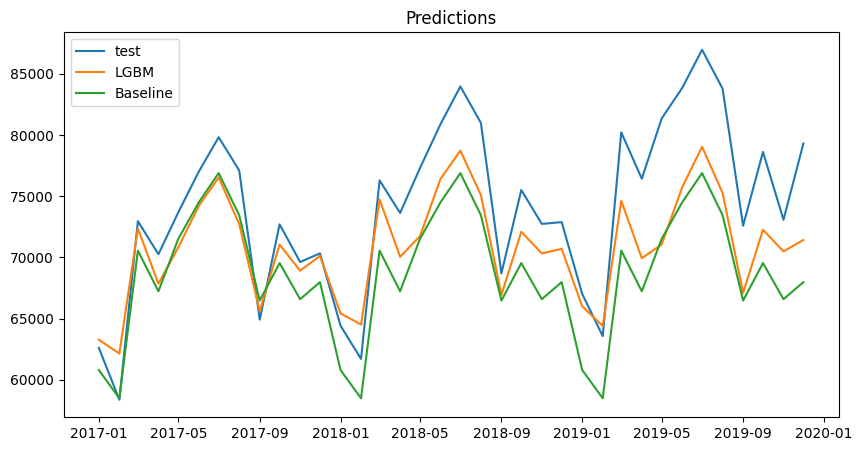

In [51]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(data_test, label='test')
plt.plot(lgbm_predict, label='LGBM')
plt.plot(baseline_predict, label='Baseline')
ax.set_title('Predictions')
ax.legend();

2.From the plot, it appears that the LGBM model does a better job predicting the test data.
3. The LBBM model has the lower mean absolute error.

In [53]:
# sklearn mean_absolute_error
mae1 = mean_absolute_error(data_test, baseline_predict)
mae1

5456.027777777777

In [55]:
# sklearn mean_absolute_error
mae2 = mean_absolute_error(data_test, lgbm_predict)
mae2

3747.904164758066

## Problem 4: Hyperparameter Tuning

We'll now try to tune your Boosting model.

Instead of using grid or random search, we'll use [Bayesian search](https://skforecast.org/0.12.1/user_guides/hyperparameter-tuning-and-lags-selection.html#bayesian-search).

Run the code below. For the best model, provide:
1. how many estimators (trees) were used? 400
2. what's the maximum depth of the trees? 4
3. learning rate? 0.3012716209280708

4. How do these compare to the default model previously run?
Matches the baseline.

Plot the tuned model's prediction and mean absolute error.

5. How does your tuned model compared to your previous Boosting model and baseline?
 Matches the baseline.

In [67]:
from skforecast.model_selection import bayesian_search_forecaster

# Hyperparameters search
# ==============================================================================
# Lags grid
lags_grid = [6, 12]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 100, 600, step=100),
        'max_depth'       : trial.suggest_int('max_depth', -1, 5, step=1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 25, 500),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
    forecaster         = forecaster2,
    y                  = data_train['ENPLANE'], # Test data not used
    search_space       = search_space,
    steps              = len(data_test),
    refit              = False,
    metric             = 'mean_absolute_error',
    initial_train_size = len(data_test),
    fixed_train_size   = False,
    n_trials           = 20, # Increase this value for a more exhaustive search
    random_state       = 123,
    return_best        = True,
    n_jobs             = 'auto',
    verbose            = False,
    show_progress      = True
)

  0%|          | 0/20 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

In [65]:
tuned_predictor = forecaster.predict(steps=len(data_test))

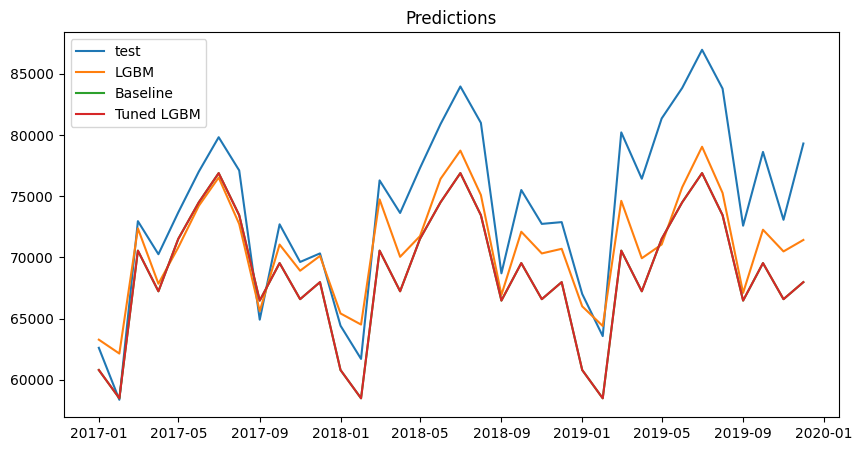

In [68]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(data_test, label='test')
plt.plot(lgbm_predict, label='LGBM')
plt.plot(baseline_predict, label='Baseline')
plt.plot(tuned_predictor, label='Tuned LGBM')
ax.set_title('Predictions')
ax.legend();

In [61]:
# sklearn mean_absolute_error
mae3 = mean_absolute_error(data_test, tuned_predictor)
mae3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5456.027777777777